# Analyze Covid-19 literature

Pubmed is a free search engine accessing primarily the MEDLINE database of references and abstracts on life sciences and biomedical topics.  A simple search for 'covid-19' on pubmed resulted in 156,871 citations, an impossible number of papers for anyone to seep through.  I set out to see whether I can get some kind of understanding of the trend in the literature using natural language processing.  

Data were downloaded from https://ftp.ncbi.nlm.nih.gov/pub/lu/LitCovid/topic_tagger/.

### <b>1.  Read data

In [1]:
# Import libraies
import nltk, pandas as pd, numpy as np, matplotlib.pyplot as plt, datetime as dt, re, random, pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
%matplotlib inline

# get stop words
stopwords = set(stopwords.words('english'))

# downloaded data from pubmed
df1 = pd.read_csv('covid19-train.csv')
df2 = pd.read_csv('covid19-test.csv')
df3 = pd.read_csv('covid19-valid.csv')

print('df1.shape: ', df1.shape)
print('df2.shape: ', df2.shape)
print('df3.shape: ', df3.shape)

df1.shape:  (52419, 12)
df2.shape:  (8226, 11)
df3.shape:  (6582, 11)


In [99]:
# combine data

df = [df1,df2,df3]
df = pd.concat(df)
df.shape

(67227, 12)

### <b>2.1 Clean data -  intial cleaning

In [45]:
# inspect the complete dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67227 entries, 0 to 6581
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pmid            67227 non-null  int64  
 1   journal         67226 non-null  object 
 2   title           67226 non-null  object 
 3   abstract        46308 non-null  object 
 4   keywords        38813 non-null  object 
 5   label           53535 non-null  object 
 6   pub_type        67224 non-null  object 
 7   authors         66593 non-null  object 
 8   date1           0 non-null      float64
 9   doi             65690 non-null  object 
 10  date2           67227 non-null  object 
 11  label_category  52419 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 6.7+ MB


In [101]:
# select only abstracts for the initial analysis

dfa = df[['pmid', 'abstract', 'date2']]
dfa.columns = ['pmid','abstract', 'date']
dfa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67227 entries, 0 to 6581
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   pmid      67227 non-null  int64 
 1   abstract  46308 non-null  object
 2   date      67227 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.1+ MB


In [102]:
# remove null values and potential duplicates. 

dfa = dfa.dropna()
print(dfa.shape)
dfa = dfa.drop_duplicates()
print(dfa.shape)

(46308, 3)
(46308, 3)


In [48]:
# check for potential short, unsable abstract. based on visual inspection, 50 word threshood is choosen.  

sorted([x for x in dfa.abstract if len(x) < 50])

['.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '...',
 'Abstract:',
 'Abstract:',
 'Abstract:',
 'Abstract:',
 'Abstract:',
 'Abstract:',
 'Abstract:',
 'Abstract:',
 'Ahead of Print article withdrawn by publisher.',
 'Ahead of Print article withdrawn by publisher.',
 'COVID-19 exposes ongoing risks to residents.',
 'COVID-19 has become pandemic [...].',
 'Calder et al [...].',
 'Click here to listen to the Podcast.',
 'Communicated by Ramaswamy H. Sarma.',
 'Communicated by Ramaswamy H. Sarma.',
 'Complete Table Top Exercise Manual.',
 'Due to an error during production, Dr [...].',
 'EDITORIAL.',
 'EDITORIAL.',
 'Editorial of vol. 32-2.',
 'Editorial.',
 'Editorial.',
 'Editorial.',
 'Graphical Abstract.',
 'Graphical Abstract.',
 'Graphical abstract.',
 'Hope for the future of global health.',
 'INTRODUCTION: METHODS: RESULTS: CONCLUSIONS:',
 'INTRODUCTION: METHODS: RESULTS: CONCLUSIONS:',
 'Image 1.',
 'Introduction:',
 'Letter to the Editor.',
 'Medicaid coverage is an opt

In [7]:
# remove abstracts with length less than 50 characters.

dfa = dfa[dfa.abstract.apply(lambda x: len(x) >= 50)]
dfa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46151 entries, 0 to 6581
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   pmid      46151 non-null  int64 
 1   abstract  46151 non-null  object
 2   date      46151 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [8]:
# change the date coloumn to datetime format

pd.to_datetime(dfa.date, infer_datetime_format=True)
print(f'Data are selected between {dfa.date.min()} and {dfa.date.max()}')

Data are selected between 1/17/2020 and 9/9/2020


In [9]:
# spot check the data

dfa.iloc[5,1]

'The COVID-19 pandemic has afflicted most countries on the planet. As a result, immunity against SARS-CoV-2, induced via natural infections or imminent vaccinations, is expected to develop in a large fraction of the global population. Here, we propose to exploit SARS-CoV-2-specific CD8(+) T cells for cancer immunotherapy strategies.'

### 2.2.  Removing non_alphabetic characters

In [104]:
#heck two letter owrds

dfa.abstract.apply(lambda x: ' '.join([w for w in x.split() if len(w)<=2]))[:10]

0    a is up to is a as of to a of we be of It be t...
1    as a to to of A of to in in to be be by of of ...
2    an of in of an of in is to to a by as to of in...
3    to as in of in of of In to of in of is on is t...
4    of We to of of In we in of 10 to 10 on to to o...
5                     on As a or is to in a of we to T
6    to of or of of We or of to of of a 8 to of up ...
7    is an by 2 in in to of in a of is of in a in o...
8    is by of in is a it a 13 by an in a of or in is a
9    of a of in a as a in of of to is is an to we o...
Name: abstract, dtype: object

In [105]:
# remove any non-alphabetic characters and words with 1 or 2 characters.  

dfw = dfa.copy()
dfw['abstract'] = dfa.abstract.str.replace(r'[^A-Za-z ]+', ' ')

# change to lower case and remove stopwords
dfw['abstract'] = dfw.abstract.apply(lambda x: ' '.join([w.lower().strip() for w in x.split() if (w.lower() not in stopwords) & (len(w)>2)]))
dfw.head(2)

,pmid,abstract,date
0,32410266,coronavirus disease covid become major global ...,5/16/2020
1,33052950,paper uses resilience lens analyse disasters m...,10/15/2020


### 2.3. Lemmatization

In [107]:
# perform lemmtization on abstracts

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

dfw['lem_abs'] = dfw.abstract.apply(lemmatize_text)
dfw.head(3)


,pmid,abstract,date,lem_abs
0,32410266,coronavirus disease covid become major global ...,5/16/2020,"[coronavirus, disease, covid, become, major, g..."
1,33052950,paper uses resilience lens analyse disasters m...,10/15/2020,"[paper, us, resilience, lens, analyse, disaste..."
2,32589531,pulmonary embolism remains important cause mor...,6/27/2020,"[pulmonary, embolism, remains, important, caus..."


### 2.4. Determine average length of abstracts

In [110]:
dfw['wc'] = dfw.lem_abs.apply(lambda x: len(x))
dfw.head(3)

,pmid,abstract,date,lem_abs,wc
0,32410266,coronavirus disease covid become major global ...,5/16/2020,"[coronavirus, disease, covid, become, major, g...",121
1,33052950,paper uses resilience lens analyse disasters m...,10/15/2020,"[paper, us, resilience, lens, analyse, disaste...",79
2,32589531,pulmonary embolism remains important cause mor...,6/27/2020,"[pulmonary, embolism, remains, important, caus...",107


In [111]:
print(f'Average words in cleaned records is {int(dfw.wc.mean())} words.')

Average words in cleaned records is 121 words.


### <b>3.  Top words analysis

In [115]:
# generate a collection of words from all the abstracts

allwords = dfw['lem_abs'].tolist()

# flatten the list
allwords = [item for sublist in allwords for item in sublist]
print(f'There are {len(allwords)} total words in all abstracts')

There are 5617655 total words in all abstracts


In [116]:
# save dfw

filename = 'dfw'
outfile = open(filename,'wb')
pickle.dump(dfw, outfile)
outfile.close()

In [3]:
# read in dfw
filename = 'dfw'
infile = open(filename,'rb')
dfw = pickle.load(infile)
infile.close()

In [117]:
# generate wordbag from all the abstracts

allwords = dfw['lem_abs'].tolist()

# flatten the list
allwords = [item for sublist in allwords for item in sublist]
print(f'There are {len(allwords)} total words in all abstracts')

There are 5617655 total words in all abstracts


In [5]:
# word frequency counts

word_freq = nltk.FreqDist(allwords)
dff = pd.DataFrame(list(word_freq.items()), columns = ['word','freq']) 
dff = dff.sort_values(by='freq', ascending=False).reset_index()
dff.head(3)

,index,word,freq
0,2,covid,134299
1,13,patient,92331
2,65,cov,46408


In [91]:
dff.describe()

,index,freq
count,58171.000000,58171.000000
mean,29085.000000,96.367073
std,16792.665591,1033.164030
min,0.000000,1.000000
25%,14542.500000,1.000000
50%,29085.000000,3.000000
75%,43627.500000,11.000000
max,58170.000000,134282.000000


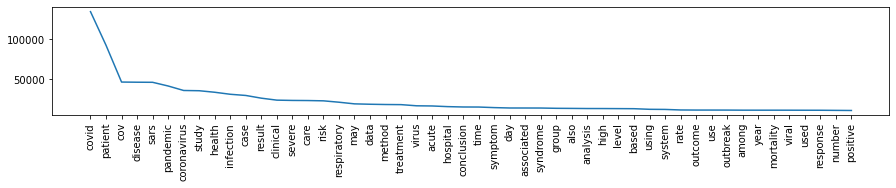

In [92]:
# plot frequency of the top 50 words that appeared more than 11 times

plt.figure(figsize=(15, 2)) 
plt.plot(dff[dff.freq > 11].word[:50], dff[dff.freq > 11].freq[:50])
plt.xticks(rotation=90);

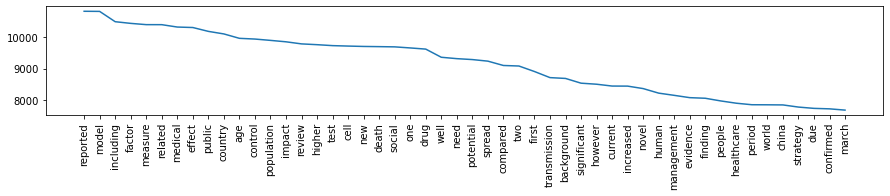

In [93]:
# plot frequency of the top 50-100 words that appeared more than 11 times

plt.figure(figsize=(15, 2)) 
plt.plot(dff[dff.freq > 11].word[50:100], dff[dff.freq > 11].freq[50:100])
plt.xticks(rotation=90);

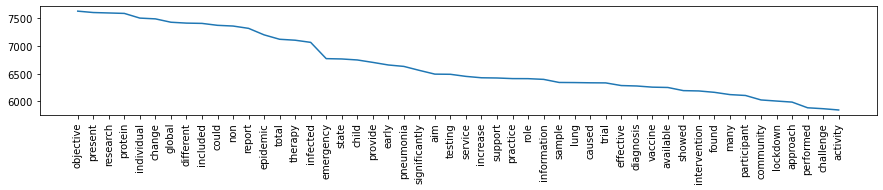

In [94]:
# plot frequency of the top 100 - 150 words that appeared more than 11 times

plt.figure(figsize=(15, 2)) 
plt.plot(dff[dff.freq > 11].word[100:150], dff[dff.freq > 11].freq[100:150])
plt.xticks(rotation=90);

Text(0.5, 1.0, 'Top 100-200 words')

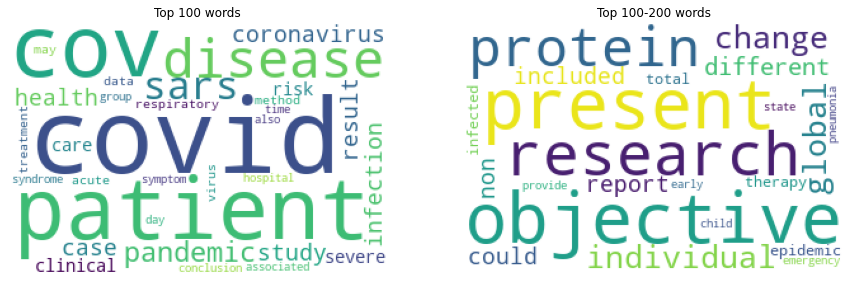

In [97]:
# generate word cloud

word100 = ' '.join(dff[dff.freq > 11].word[:100])
word200 = ' '.join(dff[dff.freq > 11].word[100:200])
wc100 = WordCloud(width = 300, height = 200,background_color ='white', stopwords = stopwords, min_font_size = 8).generate(word100)
wc200 = WordCloud(width = 300, height = 200,background_color ='white', stopwords = stopwords, min_font_size = 8).generate(word200)

plt.figure(figsize = (15, 5), facecolor = None)
ax1 = plt.subplot(1,2,1)
ax1.imshow(wc100)
ax1.axis("off")
ax1.set_title("Top 100 words")

ax2 = plt.subplot(1,2,2)
ax2.imshow(wc200)
ax2.axis("off")
ax2.set_title("Top 100-200 words")

In [98]:
print(f'About {dff[dff.freq  == 1].shape[0]} words that only appeared once.')
print(dff[dff.freq  == 1].word[:50].tolist())

About 21525 words that only appeared once.
['unenviable', 'icgs', 'syncitiotrophoblast', 'ethylbenzothiazoline', 'aromatase', 'remade', 'uruguaiana', 'counterweight', 'rhetorically', 'seguira', 'colddamp', 'zigong', 'sculpting', 'bioscientific', 'insig', 'preadmet', 'hacat', 'peumoniae', 'barriflow', 'umap', 'canoas', 'supranational', 'gblocks', 'tbars', 'phenalene', 'proximally', 'bargiggia', 'tyagi', 'leuko', 'cohens', 'finalisation', 'bansal', 'psychometrics', 'runx', 'reimpose', 'apoc', 'keratinocyte', 'nonophthalmology', 'percussive', 'supercomputer', 'abts', 'pyretics', 'nonocclusive', 'circuiting', 'ponseti', 'maroni', 'woscc', 'retromer', 'tratamento', 'vpis']


<b> Summary


1. 50% of the words were used at least 3 times while 25% words were used at least 12 times and another 25% words were used only once.  
2. based on the top words, clinical observation of patieents, the course and the spread of infetion are likely the major topics covered by the abstracts.  

3. I was hoping to get info on mechanistic studies.  But it cannot determined bebased on the top words.  

4. The above analysis indicateds that it is not feasible to get a whole picture of the literature based only on words used.



### <b>4. Label prediction uisng train, test and valid data sets

In [26]:
# select pmid, abstracts, label and date2 columns for each subdatasets provided by pubmed and clean data then randomly select 5000 records

df_train = df1[['pmid','abstract', 'label','date2']]
df_train = df_train.dropna()
# remove unusable abstracts (50 is an arbitory nubmer based on visual inspection)
df_train = df_train[df_train.abstract.apply(lambda x: len(x) >= 50)]
df_train.columns = ['pmid','abstract', 'label','date']
df_train['abstract'] = df_train.abstract.str.replace(r'[^A-Za-z ]+.', ' ')
df_train['abstract'] = df_train.abstract.apply(lambda x: ' '.join([word.lower() for word in x.split() if (word.lower() not in stopwords) and (len(word)>2)]))
print(df_train[['abstract', 'label']].head(2))

df_test = df2[['pmid','abstract', 'label','date2']]
df_test = df_test.dropna()
df_test = df_test[df_test.abstract.apply(lambda x: len(x) >= 50)]
df_test.columns = ['pmid','abstract', 'label','date']
df_test['abstract'] = df_test.abstract.str.replace(r'[^A-Za-z ]+.', ' ')
df_test['abstract'] = df_test.abstract.apply(lambda x: ' '.join([word.lower() for word in x.split() if (word.lower() not in stopwords) and (len(word)>2)]))
print(df_test[['abstract', 'label']].head(2))

df_valid = df3[['pmid','abstract', 'label','date2']]
df_valid = df_valid.dropna()
df_valid = df_valid[df_valid.abstract.apply(lambda x: len(x) >= 50)]
df_valid.columns = ['pmid','abstract', 'label','date']
df_valid['abstract'] = df_valid.abstract.str.replace(r'[^A-Za-z ]+.', ' ')
df_valid['abstract'] = df_valid.abstract.apply(lambda x: ' '.join([word.lower() for word in x.split() if (word.lower() not in stopwords) and (len(word)>2)]))
print(df_valid[['abstract', 'label']].head(2))


                                            abstract                label
0  coronavirus disease ovid become major global p...  Treatment;Mechanism
2  pulmonary embolism remains important cause mor...           Prevention
                                            abstract       label
0  companion animals pets helpful novel coronavir...  Prevention
1  background coronavirus disease ovid outbreak p...  Prevention
                                            abstract  \
0  starting december world faced unprecedented he...   
1  since covid spread world becoming pandemic ill...   

                           label  
0                     Prevention  
1  Treatment;Mechanism;Diagnosis  


In [27]:
print('df_train.shape: ', df_train.shape)
print('df_test.shape: ', df_test.shape)
print('df_valid.shape: ', df_valid.shape)

df_train.shape:  (26046, 4)
df_test.shape:  (6806, 4)
df_valid.shape:  (5422, 4)


### 2. Label prediction

In [28]:
# create a word bag from all abstracts in the train data set

a_bag = df_train['abstract'].tolist()
a_bag[5]


'coronavirus disease ovid acute respiratory viral infection caused severe acute respiratory syndrome coronavirus ars disease outbreak started china late december quickly spread rest world resulting pandemic incidence cases increasing every day affecting millions people around globe resulting public health emergency furthermore disease management challenging clinicians medical personnel terms treatment options availability personal protective equipment abel use drugs hydroxychloroquine emergency use authorization remdesivir hopefully help clinicians treating critically ill patients use convalescent serum also shown interim benefit definitive treatment preventive options uncovered vaccines effective treatment regimens.'

In [55]:
# Vectorize data for the train, test and valid data sets privided by pubmed
# using bigrams since it was difficult to extract information from single words

vectorizer = CountVectorizer(ngram_range=(1,2))
x_train = vectorizer.fit_transform(a_bag)
y_train = df_train['label']
print('train: ', x_train.shape, y_train.shape)

t_bag = df_test['abstract'].tolist()
x_test = vectorizer.fit_transform(t_bag)
print('test: ', x_test.shape)

v_bag = df_test['abstract'].tolist()
x_valid = vectorizer.fit_transform(v_bag)
print('valid: ', x_valid.shape)

train:  (26046, 1393205) (26046,)
test:  (6806, 482356)
valid:  (6806, 482356)


In [30]:
x_train1 = x_train[:, :482356]

### <b>4.1 predict labels using the Support Vector Classification of support vector machine (SVM)</b>
https://towardsdatascience.com/multiclass-classification-with-support-vector-machines-svm-kernel-trick-kernel-functions-f9d5377d6f02

In [109]:
from sklearn import svm

clf = svm.SVC()
clf.fit(x_train1, y_train)

SVC()

In [ ]:
# save model

filename = 'svc_model'
outfile = open(filename,'wb')
pickle.dump(clf, outfile)
outfile.close()

In [77]:
# read in the model

filename = 'svc_model'
infile = open(filename,'rb')
clf = pickle.load(infile)
infile.close()

In [78]:
# predict labels for the test set

pred_t = clf.predict(x_test)
print(len(pred_t))
test_label = df_test['label'].tolist()
print(len(test_label))


6806
6806


In [79]:
# save model

filename = 'pred_t'
outfile = open(filename,'wb')
pickle.dump(clf, outfile)
outfile.close()

In [80]:
# save model

filename = 'pred_t'
outfile = open(filename,'wb')
pickle.dump(clf, outfile)
outfile.close()

In [89]:
check_t = []
for i in range(len(test_label)):
    common = set(test_label[i].split(';')) & set(pred_t[i].split(';'))
    if len(list(common)) > 0:
        check_t.append(common)
print(f'The model correctly predicted about {round(len(check_t)/len(pred_t)*100, 2)}% labels in the valid set.')

The model correctly predicted about 44.92% labels in the valid set.


In [119]:
# prediction using the valid data set

pred_v = clf.predict(x_valid)
valid_label = df_valid['label'].tolist()

In [115]:
# evaluate the prediction for the valid data set

zipped_v = list(zip(valid_label, pred_v))
check_v = len([x for x in zipped_v if x[1] in x[0]])
print(f'The model correctly predicted about {round(check_v/len(pred_v)*100, 2)}% labels in the valid set.')

The model correctly predicted about 35.0% labels in the valid set.


In [120]:
# unique predicted labels
 
print(set(pred_t))
print(set(pred_v))

{'Prevention'}
{'Prevention'}


In [131]:
# unique labels in test set

ls = [x.split(';') for x in test_label]
print(set([x for y in ls for x in y ]))

{'General Info', 'Epidemic Forecasting', 'Treatment', 'Mechanism', 'Case Report', 'Diagnosis', 'Prevention', 'Transmission'}


<b> Sumamry: </b>There is only one predcted lable 'prevention'.  The model is very biased.  

### <b>4.2 Predict labels using Naive Bayes

In [56]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(x_train1,y_train)

MultinomialNB()

In [58]:
# save model

filename = 'nb_model'
outfile = open(filename,'wb')
pickle.dump(clf, outfile)
outfile.close()

In [ ]:
# read in the model

filename = 'nb_model'
infile = open(filename,'rb')
clf = pickle.load(infile)
infile.close()

In [65]:
pred_nb = clf.predict(x_test)
print(pred_nb[:5])

['General Info' 'Treatment;Mechanism;Diagnosis' 'Mechanism;Transmission'
 'Epidemic Forecasting;Prevention' 'Treatment;Prevention;Diagnosis']


In [66]:
test_label = df_test['label'].tolist()
print(test_label[:5])

['Prevention', 'Prevention', 'Prevention', 'Treatment', 'Diagnosis;Treatment']


In [72]:
test_label = df_test['label'].tolist()
print(len(pred_nb))
print(len(test_label))

6806
6806


In [73]:
check_nb = []
for i in range(len(test_label)):
    common = set(test_label[i].split(';')) & set(pred_nb[i].split(';'))
    if len(list(common)) >0:
        check_nb.append(common)

print(f'The model correctly predicted about {round(len(check_nb)/len(pred_nb)*100, 2)}% labels in the test set.')

The model correctly predicted about 35.34% labels in the test set.


In [124]:
# predict label for valid data set

pred_nbv = clf.predict(x_valid)
print(pred_nbv[:5])

['Prevention' 'Prevention' 'Prevention' 'Prevention' 'Prevention']


In [130]:
valid_label = df_valid['label'].tolist()
print(valid_label[:5])

['Prevention', 'Treatment;Mechanism;Diagnosis', 'Diagnosis', 'Prevention', 'Prevention']


In [127]:
check_nbv = []
for i in range(len(valid_label)):
    common = set(valid_label[i].split(';')) & set(pred_nbv[i].split(';'))
    if len(list(common)) > 0:
        check_nbv.append(common)

print(f'The model correctly predicted about {round(len(check_nbv)/len(pred_nbv)*100, 2)}% labels in the valid set.')

The model correctly predicted about 35.0% labels in the valid set.


### <b>5. Topic Modeling using Latent Dirichlet Allocation 

In [6]:
# read in dfw

filename = 'dfw'
infile = open(filename,'rb')
dfw = pickle.load(infile)
infile.close()

In [7]:
# create vocabulary of all the words, include words that appear in less than 80% of the document 
# and appear in at least 2 documents.  https://stackabuse.com/python-for-nlp-topic-modeling

count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')
doc_term_matrix = count_vect.fit_transform(dfw['abstract'].values.astype('U'))
doc_term_matrix

<46151x34977 sparse matrix of type '<class 'numpy.int64'>'
	with 3754990 stored elements in Compressed Sparse Row format>

<b>5.1.   Using LDA model to analyze 8 topics

In [20]:
LDA_8t = LatentDirichletAllocation(n_components=8, random_state=42)
LDA_8t.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=8, random_state=42)

In [26]:
# save model

filename = 'lda_8t'
outfile = open(filename,'wb')
pickle.dump(LDA_8t, outfile)
outfile.close()

In [91]:
# read in LDA

filename = 'lda_8t'
infile = open(filename,'rb')
LDA_8t = pickle.load(infile)
infile.close()

In [136]:
# find words with the highest probability for the first topic

first_topic = LDA_8t.components_[0]
top_words  = [count_vect.get_feature_names()[w] for w in first_topic.argsort()[-10:]]
print(f'Top words for topic #0 of 8:')
print(top_words)

Top words for topic #0 of 8:
['vaccine', 'drug', 'drugs', 'human', 'protein', 'viral', 'coronavirus', 'virus', 'sars', 'cov']


In [92]:
# save top words with highest probabilities for 8 topics.

top_ls8t = []
for i,topic in enumerate(LDA_8t.components_):
    top_words = sorted([count_vect.get_feature_names()[w] for w in topic.argsort()[-10:]])
    top_ls8t.append(top_words)

In [42]:
# print top word lists for all the topics

for item in top_ls8t:
    print(item)

['coronavirus', 'cov', 'drug', 'drugs', 'human', 'protein', 'sars', 'vaccine', 'viral', 'virus']
['cases', 'clinical', 'coronavirus', 'disease', 'patients', 'pneumonia', 'results', 'severe', 'studies', 'study']
['cases', 'china', 'countries', 'data', 'disease', 'epidemic', 'health', 'model', 'number', 'spread']
['anxiety', 'health', 'mental', 'pandemic', 'participants', 'psychological', 'results', 'social', 'study', 'survey']
['coronavirus', 'cov', 'disease', 'infection', 'patients', 'positive', 'respiratory', 'sars', 'severe', 'syndrome']
['age', 'cancer', 'care', 'disease', 'hospital', 'mortality', 'patients', 'results', 'risk', 'study']
['care', 'coronavirus', 'disease', 'health', 'healthcare', 'management', 'medical', 'pandemic', 'public', 'research']
['acute', 'coronavirus', 'cov', 'disease', 'immune', 'infection', 'patients', 'respiratory', 'sars', 'severe']


In [137]:
# unique labels in the original data set

label = df.label.dropna()
label.head()

0    Treatment;Mechanism
2             Prevention
4    Treatment;Diagnosis
5    Treatment;Mechanism
6    Treatment;Diagnosis
Name: label, dtype: object

In [139]:
# unique labels in df

ul = [x.split(';') for x in label]
print(set([x for y in ul for x in y ]))

{'General Info', 'Epidemic Forecasting', 'Treatment', 'Mechanism', 'Case Report', 'Diagnosis', 'Prevention', 'Transmission'}


In [164]:
# longest label in df

ll = [x.split(';') for x in label]
max_len = -1
for x in ll:
    if len(x) > max_len:
        max_len = len(x)
        res = '; '.join(x)
print(f'Maximum length label is "{res}"')

Maximum length label is "Transmission; Prevention; Mechanism; Treatment; Diagnosis"


In [170]:
# find most used label

ls = [x for y in ll for x in y]

# word frequency counts
word_freq = nltk.FreqDist(ls)
dfl = pd.DataFrame(list(word_freq.items()), columns = ['label','freq']) 
dfl = dfl.sort_values(by='freq', ascending=False).reset_index()
dfl


,index,label,freq
0,2,Prevention,24191
1,0,Treatment,16999
2,3,Diagnosis,11969
3,1,Mechanism,8195
4,5,Case Report,4474
5,4,Transmission,2047
6,7,General Info,1738
7,6,Epidemic Forecasting,1026


In [180]:
print(f'"Prevention" accounts for {round(dfl.iloc[0,2]/dfl.freq.sum()*100, 2)}% of all labels used.')

"Prevention" accounts for 34.25% of all labels used.


<b>5.2.   Using LDA model to analyze 15 topics

In [59]:
# creating LDA model for 15 topics

LDA_15t = LatentDirichletAllocation(n_components=15, random_state=42)
LDA_15t.fit(doc_term_matrix)

# save model
filename = 'lda_15t'
outfile = open(filename,'wb')
pickle.dump(LDA_15t, outfile)
outfile.close()

LatentDirichletAllocation(n_components=15, random_state=42)

In [93]:
# read in LDA

filename = 'lda_15t'
infile = open(filename,'rb')
LDA_15t = pickle.load(infile)
infile.close()

In [94]:
#  save top words with highest probabilities for 15 topics.

top_ls15t = []
for i,topic in enumerate(LDA_15t.components_):
    top_words = sorted([count_vect.get_feature_names()[w] for w in topic.argsort()[-10:]])
    top_ls15t.append(top_words)

In [45]:
# print top word lists for the 15 topics

for item in top_ls15t:
    print(item)

['binding', 'coronavirus', 'cov', 'drug', 'drugs', 'human', 'protein', 'sars', 'viral', 'virus']
['cases', 'chest', 'clinical', 'coronavirus', 'disease', 'findings', 'lung', 'patients', 'pneumonia', 'severe']
['cases', 'china', 'countries', 'data', 'disease', 'epidemic', 'model', 'number', 'spread', 'transmission']
['anxiety', 'health', 'mental', 'pandemic', 'participants', 'psychological', 'results', 'social', 'study', 'survey']
['acute', 'coronavirus', 'cov', 'disease', 'infection', 'patients', 'respiratory', 'sars', 'severe', 'syndrome']
['clinical', 'days', 'group', 'hospital', 'median', 'mortality', 'patients', 'severe', 'study', 'treatment']
['countries', 'disease', 'economic', 'food', 'global', 'health', 'pandemic', 'people', 'public', 'vaccine']
['ace', 'cell', 'cells', 'cov', 'disease', 'immune', 'infection', 'inflammatory', 'sars', 'severe']
['cancer', 'care', 'disease', 'health', 'management', 'pandemic', 'patient', 'patients', 'surgery', 'surgical']
['care', 'clinical', 'he

### <b> 6. Recommending/selecting papers using top words  </b>

In [46]:
# count abstracts contain 90% of the top words for each of the 8 topics

dfs8t = {}
for i,ls in enumerate(top_ls8t):
    dfs8t[i] = dfw[dfw.lem_abs.apply(lambda x: len(list(set(x) & set(top_ls8t[i]))) >= len(top_ls8t[i])*0.9)]
    print(f'There are {dfs8t[i].shape[0]} records contain more than 90% top words in topic {i} of 8')

There are 26 records contain more than 90% top words in topic 0 of 8
There are 0 records contain more than 90% top words in topic 1 of 8
There are 0 records contain more than 90% top words in topic 2 of 8
There are 0 records contain more than 90% top words in topic 3 of 8
There are 578 records contain more than 90% top words in topic 4 of 8
There are 0 records contain more than 90% top words in topic 5 of 8
There are 14 records contain more than 90% top words in topic 6 of 8
There are 553 records contain more than 90% top words in topic 7 of 8


In [47]:
# count abstracts contain 90% of the top 10 words for each of the 15 topics

dfs15t = {}
for i,ls in enumerate(top_ls15t):
    dfs15t[i] = dfw[dfw.lem_abs.apply(lambda x: len(list(set(x) & set(top_ls15t[i]))) >= len(top_ls15t[i])*0.9)]
    print(f'There are {dfs15t[i].shape[0]} records contain more than 90% top words in topic {i} of 15')

There are 27 records contain more than 90% top words in topic 0 of 15
There are 0 records contain more than 90% top words in topic 1 of 15
There are 0 records contain more than 90% top words in topic 2 of 15
There are 0 records contain more than 90% top words in topic 3 of 15
There are 3030 records contain more than 90% top words in topic 4 of 15
There are 0 records contain more than 90% top words in topic 5 of 15
There are 0 records contain more than 90% top words in topic 6 of 15
There are 30 records contain more than 90% top words in topic 7 of 15
There are 7 records contain more than 90% top words in topic 8 of 15
There are 2 records contain more than 90% top words in topic 9 of 15
There are 0 records contain more than 90% top words in topic 10 of 15
There are 0 records contain more than 90% top words in topic 11 of 15
There are 0 records contain more than 90% top words in topic 12 of 15
There are 21 records contain more than 90% top words in topic 13 of 15
There are 2 records cont

In [30]:
# Topic #4 was discussed in the highest number of records in both sets using 8 or 15 topics

print('topic words in topic #4 of 8 topics: ')
print(sorted(top_ls8t[4]))
print('topic words in topic #4 of 15 topics: ')
print(sorted(top_ls15t[4]))

topic words in topic #4 of 8 topics: 
['coronavirus', 'cov', 'disease', 'infection', 'patients', 'positive', 'respiratory', 'sars', 'severe', 'syndrome']
topic words in topic #4 of 15 topics: 
['acute', 'coronavirus', 'cov', 'disease', 'infection', 'patients', 'respiratory', 'sars', 'severe', 'syndrome']


In [36]:
print(f'Top ten words in topic#4 is {len(list(set(top_ls15t[4]) & set(top_ls8t[4])))/len(set(top_ls8t[4]))*100}% identical in both sets')

Top ten words in topic#4 is 90.0% identical in both sets


In [98]:
# Shown top ten words in topic #7, which is discussed in the second highest number of records in both sets

print('topic words in topic #7 of 8 topics: ')
print(sorted(top_ls8t[7]))
print('topic words in topic #7 of 15 topics: ')
print(sorted(top_ls15t[7]))
print()
print(f'Top ten words in topic#7 is {len(list(set(top_ls15t[7]) & set(top_ls8t[7])))/len(set(top_ls8t[7]))*100}% identical in both sets')

topic words in topic #7 of 8 topics: 
['acute', 'coronavirus', 'cov', 'disease', 'immune', 'infection', 'patients', 'respiratory', 'sars', 'severe']
topic words in topic #7 of 15 topics: 
['ace', 'cell', 'cells', 'cov', 'disease', 'immune', 'infection', 'inflammatory', 'sars', 'severe']

Top ten words in topic#7 is 60.0% identical in both sets


It appears that top topics when usig 8 topics or 15 topics are very similar.  8 topics is likely sufficient for the topic analysis.

In [37]:
# find top ten papers that cover topic#4 of 8 topics

print('Top ten papers cover topic #4 of 8 topics: ')
print(dfs8t[4][['pmid', 'abstract', 'date']].head(10))

Top ten papers cover topic #4 of 8 topics: 
         pmid                                           abstract       date
28   32726441  background severe acute respiratory syndrome c...  7/30/2020
86   32461325  background anosmia dysgeusia reported potentia...  5/29/2020
97   32656172  background outbreak severe acute respiratory s...  7/14/2020
146  32776022  background novel coronavirus disease covid cau...  8/11/2020
207  32584236  novel coronavirus pandemic poses major global ...  6/26/2020
219  32617223  coronavirus disease covid highly infectious di...   7/4/2020
244  32730827  background studies explored air surface contam...  7/31/2020
250  32370924  coronavirus disease covid pandemic caused seve...   5/7/2020
295  32368850  severe acute respiratory syndrome coronavirus ...   5/6/2020
379  33017040  ongoing pandemic coronavirus disease covid cau...  10/6/2020


<b>Summary</b>

1. In this study, I imported csv files from pubmed that contains the dumped data for 2019-2020.  Three types of analysis were performed to get some insight on covid literature.
<br/><br/>
2. The first attempt was to examine the top words in the whole data set to see what insights one might be able to infer from the data.  I found that one can get a sense of what was discussed based on top words.  But, there is limit to get indepth information based on top words.
<br/><br/>
3. Next I took the advange of train test and validate data sets that have prelabels for the type of study for the abstract.  I tranied a SVC and predicted the labels for the test and validation data sets.  The labels in the train set has one or more labels.  The model was able to make about 44% correct predictions if one consider as long as the predicted label is one of the words in the set, it is a correct prediction. <br/><br/> 

4. A detailed examination of the result shown that only one label was predicted by the model, which accounts for about 35% of all labels in the original data set.  <br/><br/>

5. Next, I did prediction using Naive Bayes classifier to perform label prediction.  The overall correct prediction is less than 40%.    <br/><br/>

6. Thirdly, I performed topic modeling using Latent Dirichlet Allocation (LDA) method.  Since the original data sets has eight differnt labels, I first performed the analysis using 8 topics.  Then also tried 15 topics.  Based on the top ten words for the mostly discussed topic, I concluded that 8 topics is sufficient for teasing out the difference in topics.  Based on this analysis, it is possible to pick out papers that disccuss certain topics.  